In [100]:
# -*- coding: utf-8 -*-
"""
Jupyter Notebook for Analyzing F1TENTH Localization Performance

This notebook analyzes localization data collected from F1TENTH experiments
to compare a new localization method against state-of-the-art implementations.

Data structure per log file (assumed CSV):
timestamp, current_speed, current_x, current_y, current_yaw,
ground_truth_x, ground_truth_y, ground_truth_yaw, lap
"""

# %% [markdown]
# # F1TENTH Localization Performance Analysis
#
# **Objective:** Evaluate the performance of a new localization method against three other SOTA methods using data collected across 7 race tracks, 4 speeds, and 4 laps per condition.
#
# **Methodology:**
# 1. Load and preprocess experimental data.
# 2. Calculate position and orientation errors relative to ground truth.
# 3. Visualize trajectories and error characteristics.
# 4. Compute quantitative performance metrics (RMSE, Mean, Median, Max error).
# 5. Compare methods based on accuracy, consistency, and robustness to speed changes.

# %% [markdown]
# ## 1. Setup
#
# Import necessary libraries and define helper functions.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # For potentially handling multiple files

# Set plot style
sns.set_theme(style="whitegrid")

# %%
def calculate_position_error(row):
    """Calculates the Euclidean distance between estimated and ground truth position."""
    return np.sqrt((row['current_x'] - row['ground_truth_x'])**2 +
                   (row['current_y'] - row['ground_truth_y'])**2)

def normalize_angle(angle):
    """Normalize an angle to the range [-pi, pi]."""
    return (angle + np.pi) % (2 * np.pi) - np.pi

def calculate_yaw_error(row):
    """Calculates the absolute difference between estimated and ground truth yaw, handling wrap-around."""
    error = row['current_yaw'] - row['ground_truth_yaw']
    return np.abs(normalize_angle(error))

# Optional: Function to calculate Root Mean Square Error (RMSE)
def rmse(errors):
    """Calculates the Root Mean Square Error."""
    return np.sqrt(np.mean(np.square(errors)))

# ## 2. Data Loading and Preprocessing
#
# Load the data from your files. You might need to adapt this part depending on how your data is stored (e.g., one big file, one file per run). Let's assume you have multiple CSV files, and we can identify the track, method, and speed from the filename or a structure.
#
# **Assumption:** You have a way to map filenames or directories to track, method, and speed. We'll create placeholder columns for these. You'll need to implement the actual loading logic.

In [101]:

data_directory = '/home/amandoee/sim_ws/data_collected_with_normal_also'
all_data = []

for track_name in ['map0','map0_slamversion','map2','map2_slamversion', 'Spielberg','Spielberg_slamversion','tavler1']:
    for speed_value in ['5.0', '6.0', '7.0', '8.0']:
        for method_name in ['amcl', 'conv', 'odom', 'slam']:
            # Construct filename based on your naming convention
            filename = f"/{track_name}/{method_name}/{track_name}_{method_name}_logged_datawith_speed_{speed_value}.csv"
            filepath = data_directory+filename
            try:
                # Load the specific CSV
                df_run = pd.read_csv(filepath)

                # Add identifying columns
                df_run['track'] = track_name
                df_run['method'] = method_name
                df_run['speed_setting'] = speed_value # Use a descriptive name for the commanded speed

                all_data.append(df_run)

            except FileNotFoundError:
                try:
                    # Load the specific CSV
                    df_run = pd.read_csv(data_directory+f"/{track_name}/{method_name}/{track_name}_{method_name}_logged_datawith_speed_{speed_value}_crash.csv")

                    # Add identifying columns
                    df_run['track'] = track_name
                    df_run['method'] = method_name
                    df_run['speed_setting'] = speed_value # Use a descriptive name for the commanded speed

                    all_data.append(df_run)
                except FileNotFoundError:

                    print(f"Warning: File not found for {track_name}, {method_name}, {speed_value}. Skipping.")
                    continue # Skip if a file is missing

# Combine all data into a single DataFrame
if not all_data:
    raise ValueError("No data loaded. Check data directory and file naming.")

df = pd.concat(all_data, ignore_index=True)

#print(f"Loaded data shape: {df.shape}")
#print(df.head())
#print("\nUnique values:")
#print(f"Tracks: {df['track'].unique()}")
#print(f"Methods: {df['method'].unique()}")
#print(f"Speeds: {df['speed_setting'].unique()}")


%% [markdown]
## 3. Error Calculation

Calculate position and yaw errors for each data point.

%%

In [102]:



df.loc[df['lap'] >= 1, 'position_error'] = df.loc[df['lap'] >= 1].apply(calculate_position_error, axis=1)
df.loc[df['lap'] >= 1, 'yaw_error'] = df.loc[df['lap'] >= 1].apply(calculate_yaw_error, axis=1)
df.loc[df['lap'] >= 1, 'yaw_error_deg'] = np.degrees(df.loc[df['lap'] >= 1, 'yaw_error']) # Often useful to see error in degrees

# Keep track of which combinations of track, method, speed, and lap have errors above 10 m
high_error_combinations = df.loc[df['position_error'] > 10, ['track', 'method', 'speed_setting', 'lap']].drop_duplicates()
print("\nCombinations with position errors above 10 m:")
#Remove all high error combinations from the DataFrame
df = df[~df.set_index(['track', 'method', 'speed_setting', 'lap']).index.isin(high_error_combinations.set_index(['track', 'method', 'speed_setting', 'lap']).index)]


print("\nDataFrame with errors:")
print(df[['timestamp', 'method', 'speed_setting', 'lap', 'position_error', 'yaw_error_deg']].head())


#Find all runs with errors above 10 m




Combinations with position errors above 10 m:

DataFrame with errors:
                    timestamp method speed_setting  lap  position_error  \
0  2025-05-12T11:12:05.001729   amcl           5.0  0.0             NaN   
1  2025-05-12T11:12:05.005789   amcl           5.0  0.0             NaN   
2  2025-05-12T11:12:05.009816   amcl           5.0  0.0             NaN   
3  2025-05-12T11:12:05.013928   amcl           5.0  0.0             NaN   
4  2025-05-12T11:12:05.017645   amcl           5.0  0.0             NaN   

   yaw_error_deg  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  


 %% [markdown]
# ## 4. Visualizations
#
# Generate plots to compare the localization methods.

# %% [markdown]
# ### 4.1 Trajectory Plots
#
# Plot the estimated trajectory vs. the ground truth trajectory. Select a representative example (e.g., one specific track, speed, and lap) to compare all methods visually. Repeat for a few key examples if needed.

# %%
# # --- Select data for a specific representative run ---

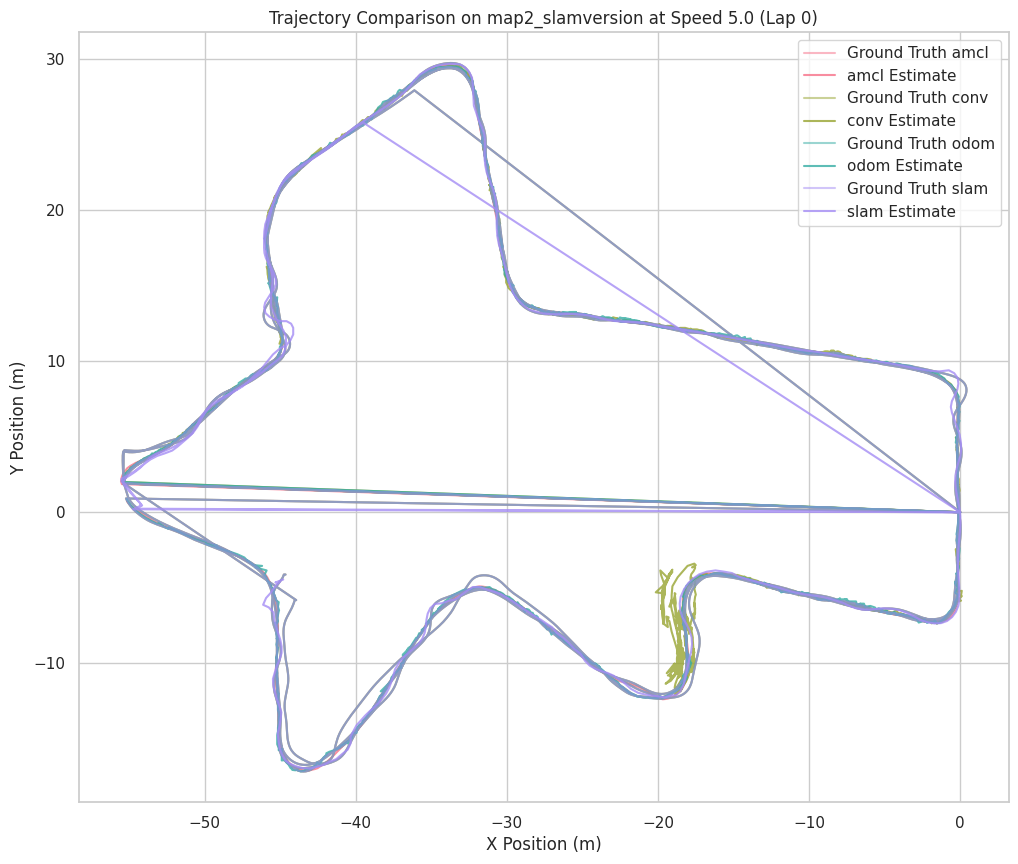

In [103]:
track_to_plot = df['track'].unique()[3] # Choose the first track
speed_to_plot = df['speed_setting'].unique()[0] # Choose the first speed
lap_to_plot = 0 # Choose the first lap

df_plot_traj = df[(df['track'] == track_to_plot) &
                  (df['speed_setting'] == speed_to_plot) &
                  (df['lap'] == lap_to_plot)
                  ]

if df_plot_traj.empty:
    print(f"Warning: No data found for Track={track_to_plot}, Speed={speed_to_plot}, Lap={lap_to_plot}")
else:
    methods_to_plot = df_plot_traj['method'].unique()

    plt.figure(figsize=(12, 10))


    # Plot estimated trajectory for each method
    for method in methods_to_plot:

        #Plot ground truth trajectory
        plt.plot(df_plot_traj['ground_truth_x'].to_numpy(), df_plot_traj['ground_truth_y'].to_numpy(), label=f'Ground Truth {method}', alpha=0.5, c=sns.color_palette("husl", len(methods_to_plot))[list(methods_to_plot).index(method)])
        # Plot estimated trajectory
        method_data = df_plot_traj[df_plot_traj['method'] == method]
        plt.plot(method_data['current_x'].to_numpy(), method_data['current_y'].to_numpy(), label=f'{method} Estimate', alpha=0.8,c=sns.color_palette("husl", len(methods_to_plot))[list(methods_to_plot).index(method)])

    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title(f'Trajectory Comparison on {track_to_plot} at Speed {speed_to_plot} (Lap {lap_to_plot})')
    plt.legend()
    plt.axis('equal') # Ensure aspect ratio is equal
    plt.grid(True)
    # plt.savefig(f'trajectory_{track_to_plot}_{speed_to_plot}_lap{lap_to_plot}.png') # Optional: Save plot
    plt.show()

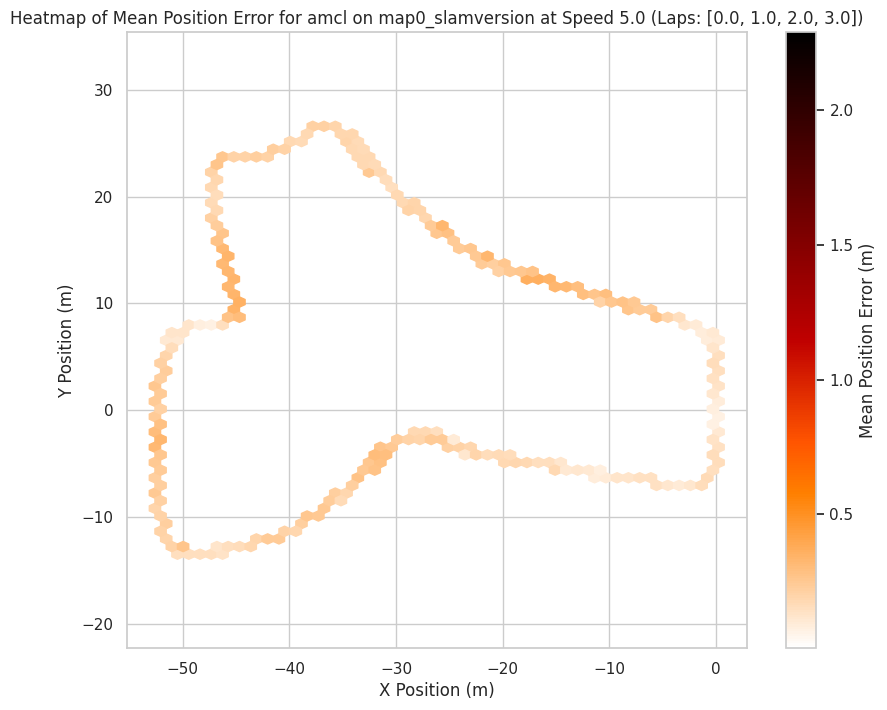

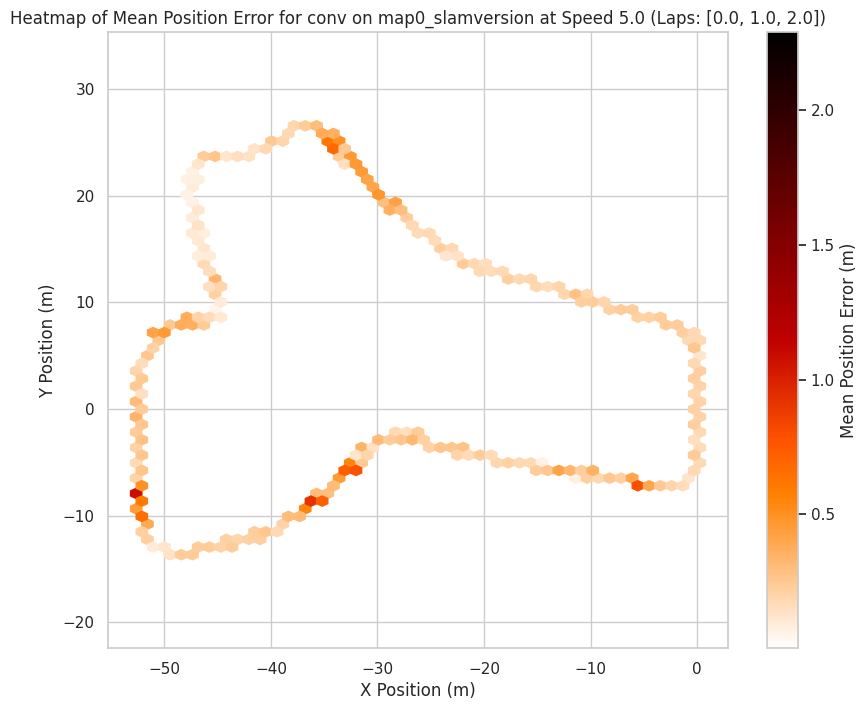

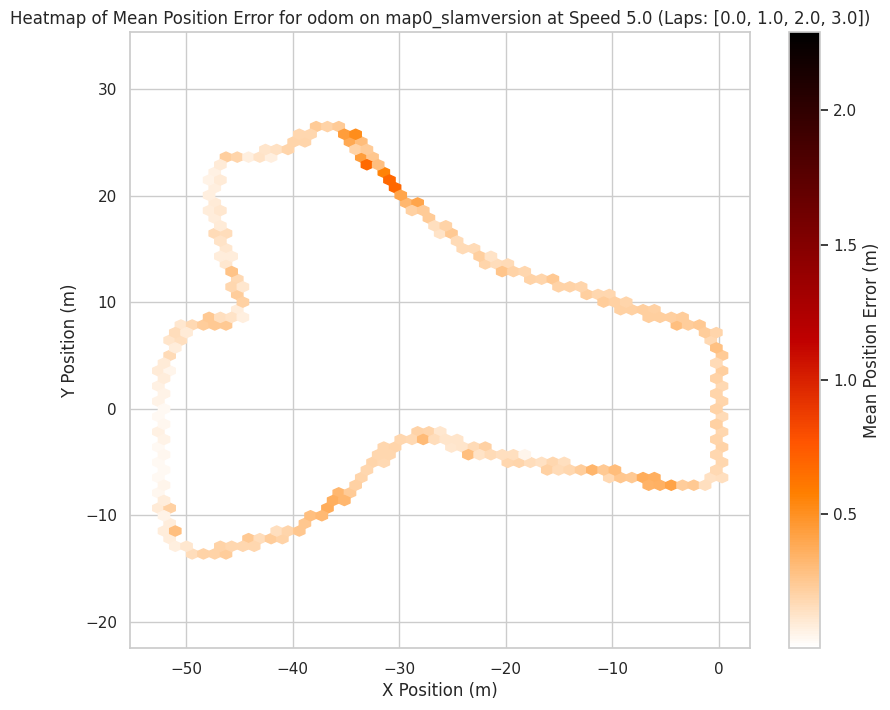


Summary Table of Results:
  Method             Track Speed        Laps Completed  Mean Error  \
0   amcl  map0_slamversion   5.0  [0.0, 1.0, 2.0, 3.0]    0.200398   
1   conv  map0_slamversion   5.0       [0.0, 1.0, 2.0]    0.246878   
2   odom  map0_slamversion   5.0  [0.0, 1.0, 2.0, 3.0]    0.196242   

   Median Error  Max Error  Min Error  Std Dev Error  
0      0.180575   0.846997   0.001449       0.123010  
1      0.190256   2.290254   0.003855       0.217135  
2      0.171097   1.476690   0.001891       0.156183  


In [117]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

track_to_plot = df['track'].unique()[1]
speed_to_plot = df['speed_setting'].unique()[0]
lap_to_plot = [3]



df_plot_traj = df[(df['track'] == track_to_plot) &
                  (df['speed_setting'] == speed_to_plot) & (df['lap'] >= 0)].copy()

if df_plot_traj.empty:
    print(f"Warning: No data found for Track={track_to_plot}, Speed={speed_to_plot}, Lap={lap_to_plot}")
else:
    methods_to_plot = df_plot_traj['method'].unique()




    # Determine the global range of position errors for consistent color scaling
    vmin = df_plot_traj['position_error'].min()
    vmax = df_plot_traj['position_error'].max()

    results = []

    for method in methods_to_plot:
        method_data = df_plot_traj[df_plot_traj['method'] == method]
        x = method_data['ground_truth_x'].to_numpy()
        y = method_data['ground_truth_y'].to_numpy()
        errors = method_data['position_error'].to_numpy()

        #Check if the method has any non-nan values
        if np.isnan(errors).all():
            print(f"Warning: All errors are NaN for method {method}. Skipping this method.")
            continue

        laps_completed_for_method_and_speed = df_plot_traj[(df_plot_traj['method'] == method) & (df_plot_traj['speed_setting'] == speed_to_plot)]['lap'].unique().tolist()

        # Calculate statistics for the data table
        mean_error = np.nanmean(errors)
        median_error = np.nanmedian(errors)
        max_error = np.nanmax(errors)
        min_error = np.nanmin(errors)
        std_error = np.nanstd(errors)

        results.append({
            'Method': method,
            'Track': track_to_plot,
            'Speed': speed_to_plot,
            'Laps Completed': laps_completed_for_method_and_speed,
            'Mean Error': mean_error,
            'Median Error': median_error,
            'Max Error': max_error,
            'Min Error': min_error,
            'Std Dev Error': std_error
        })

        # Plot heatmap
        plt.figure(figsize=(10, 8))
        plt.hexbin(x, y, C=errors, cmap='gist_heat_r', gridsize=50, reduce_C_function=np.mean, vmin=vmin, vmax=vmax)
        cb = plt.colorbar(label='Mean Position Error (m)')
        plt.xlabel('X Position (m)')
        plt.ylabel('Y Position (m)')
        plt.title(f'Heatmap of Mean Position Error for {method} on {track_to_plot} at Speed {speed_to_plot} (Laps: {laps_completed_for_method_and_speed})')
        plt.axis('equal')
        plt.grid(True)
        plt.savefig(f'mean_pos_error_heatmaps/heatmap_{method}_{track_to_plot}_{speed_to_plot}_laps{laps_completed_for_method_and_speed}.png')  # Optional: Save plot
        plt.show()

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results)
    print("\nSummary Table of Results:")
    print(results_df)

    # Optionally save the results to a CSV file
    results_df.to_csv(f'mean_pos_error_heatmaps/results_{track_to_plot}_{speed_to_plot}.csv', index=False)



# ### 4.2 Error Over Time
#
# Plot position and yaw errors over time for the same representative run. This helps visualize error behavior during the lap.

# %%

In [105]:

if False and not df_plot_traj.empty:
    print(1)
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)


    # Plot Position Error

    sns.lineplot(data=df_plot_traj, x='timestamp', y='position_error', hue='method', ax=axes[0])
    print(2)

    axes[0].set_ylabel('Position Error (m)')

    axes[0].set_title(f'Position Error Over Time on {track_to_plot} at Speed {speed_to_plot} (Lap {lap_to_plot})')

    axes[0].legend(title='Method')

    axes[0].grid(True)


    # Plot Yaw Error

    sns.lineplot(data=df_plot_traj, x='timestamp', y='yaw_error_deg', hue='method', ax=axes[1])

    axes[1].set_ylabel('Yaw Error (degrees)')

    axes[1].set_xlabel('Time (s)')

    axes[1].set_title(f'Yaw Error Over Time on {track_to_plot} at Speed {speed_to_plot} (Lap {lap_to_plot})')

    axes[1].get_legend().remove() # Remove duplicate legend

    axes[1].grid(True)


    plt.tight_layout()

    # plt.savefig(f'error_time_{track_to_plot}_{speed_to_plot}_lap{lap_to_plot}.png') # Optional: Save plot

    plt.show() 

# %% [markdown]
# ### 4.3 Error Distribution (Box Plots)
#
# Use box plots to compare the distribution of errors (position and yaw) across all methods. You can aggregate across all tracks/speeds/laps, or facet by track or speed. Aggregating first gives a good overview.

# %%
# # Aggregate across all conditions first

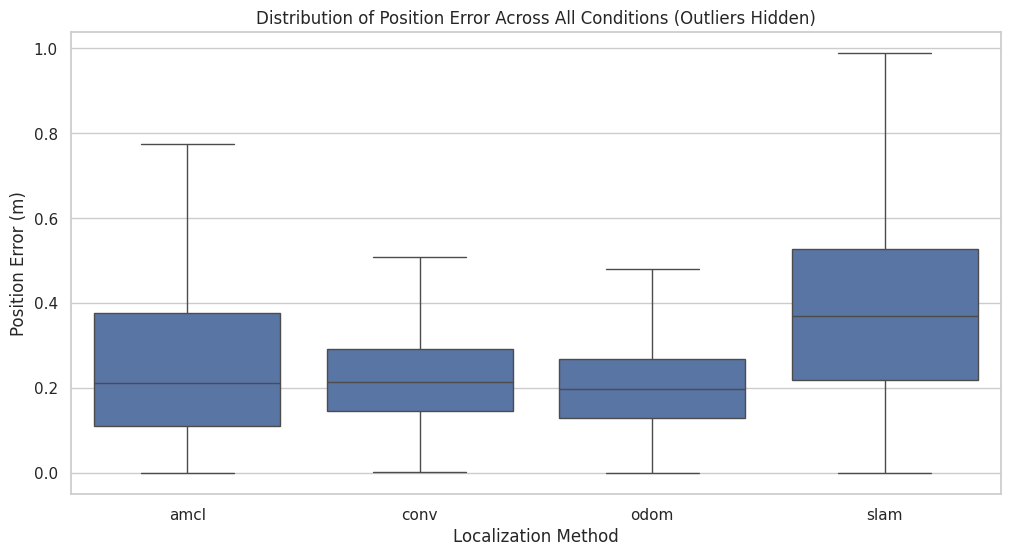

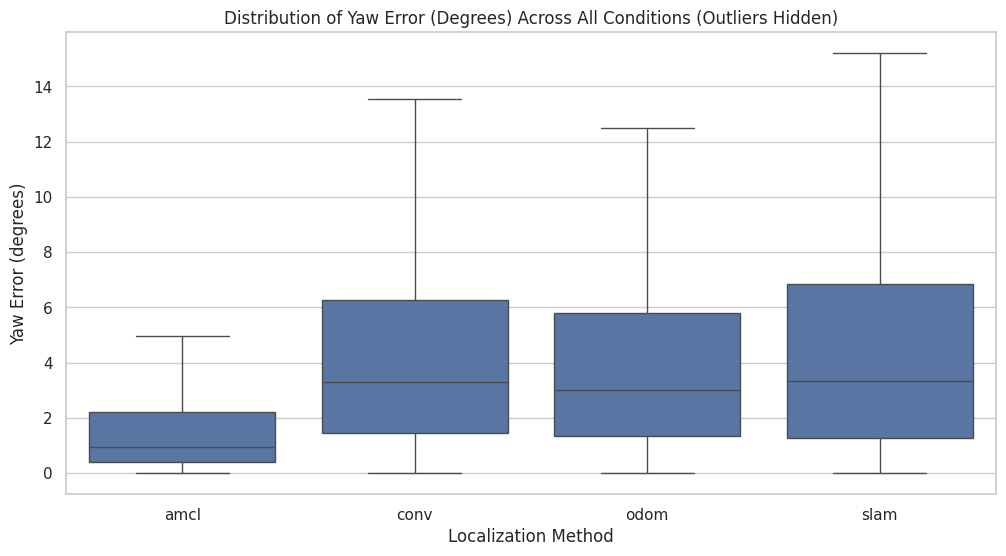

In [106]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='method', y='position_error', showfliers=False) # showfliers=False to avoid outlier distraction initially
plt.title('Distribution of Position Error Across All Conditions (Outliers Hidden)')
plt.xlabel('Localization Method')
plt.ylabel('Position Error (m)')
# plt.savefig('boxplot_pos_error_all.png')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='method', y='yaw_error_deg', showfliers=False)
plt.title('Distribution of Yaw Error (Degrees) Across All Conditions (Outliers Hidden)')
plt.xlabel('Localization Method')
plt.ylabel('Yaw Error (degrees)')
# plt.savefig('boxplot_yaw_error_all.png')
plt.show()


# %% [markdown]
# #### Error Distribution Faceted by Speed
# This shows how the error distributions change with speed for each method.

# %%

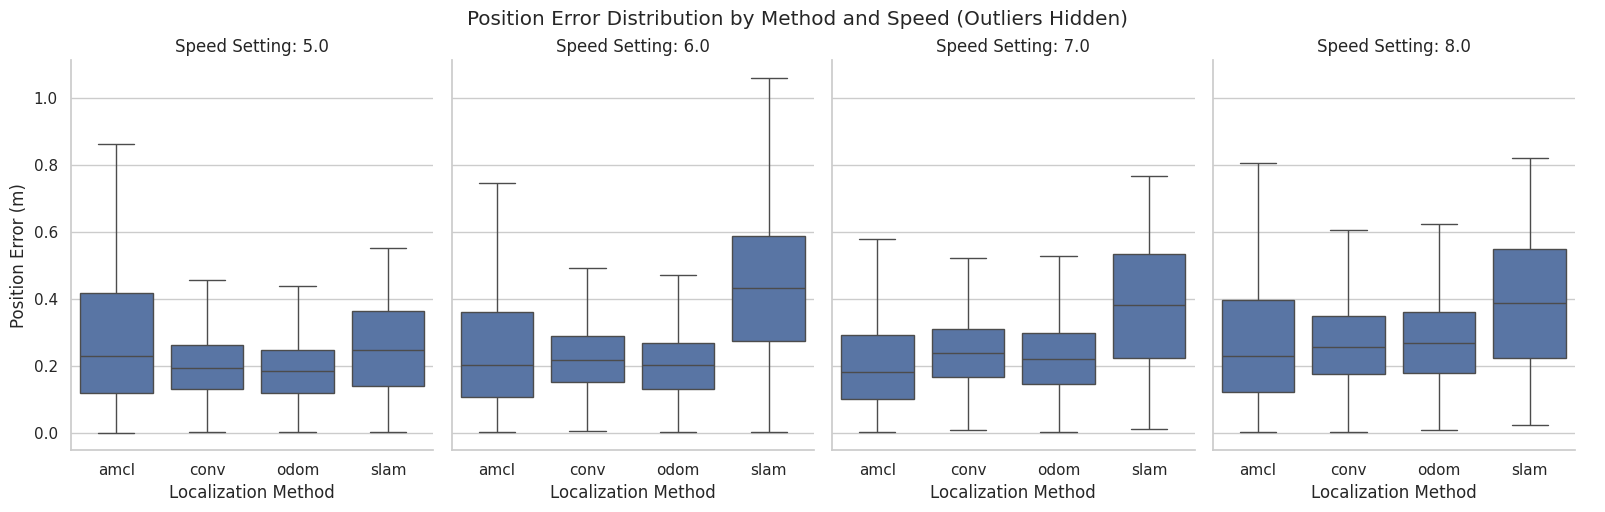

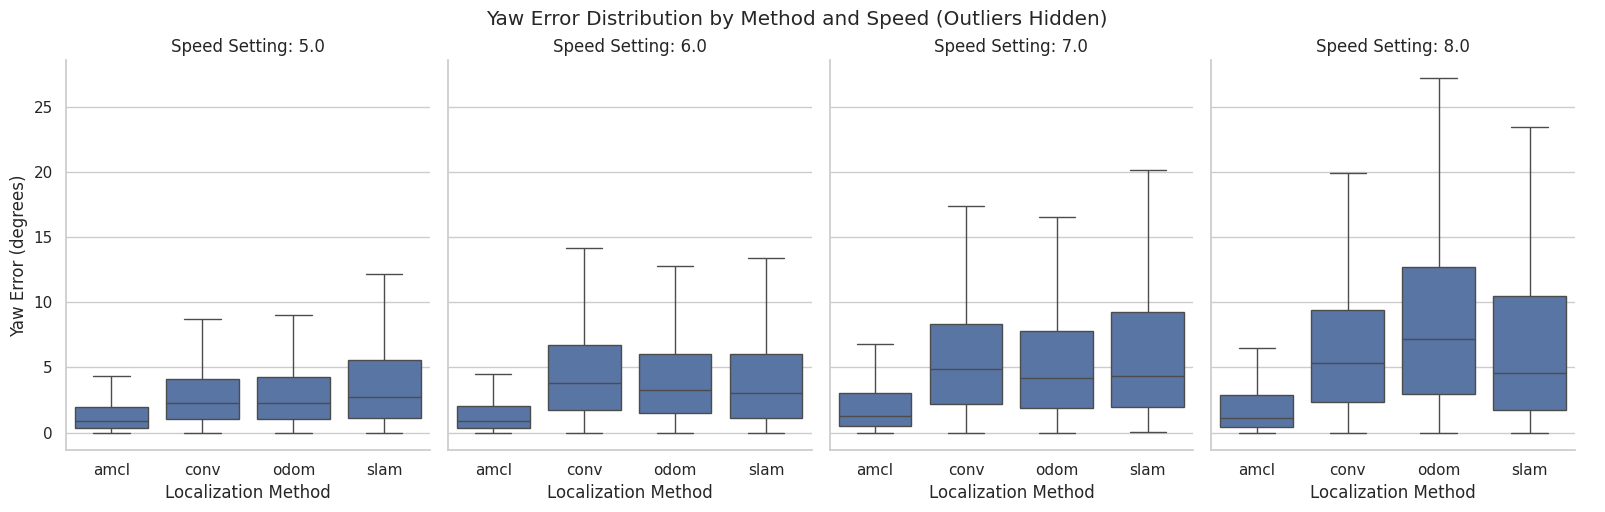

In [107]:

g = sns.catplot(data=df, x='method', y='position_error', col='speed_setting',
                kind='box', showfliers=False, height=5, aspect=0.8)
g.fig.suptitle('Position Error Distribution by Method and Speed (Outliers Hidden)', y=1.02)
g.set_axis_labels('Localization Method', 'Position Error (m)')
g.set_titles('Speed Setting: {col_name}')
# plt.savefig('boxplot_pos_error_by_speed.png')
plt.show()

g = sns.catplot(data=df, x='method', y='yaw_error_deg', col='speed_setting',
                kind='box', showfliers=False, height=5, aspect=0.8)
g.fig.suptitle('Yaw Error Distribution by Method and Speed (Outliers Hidden)', y=1.02)
g.set_axis_labels('Localization Method', 'Yaw Error (degrees)')
g.set_titles('Speed Setting: {col_name}')
# plt.savefig('boxplot_yaw_error_by_speed.png')
plt.show()


# %% [markdown]
# ### 4.4 Performance vs. Speed
#
# Plot average error metrics (e.g., Mean Position Error, RMSE of Position Error) against the speed setting for each method. This explicitly shows robustness to speed changes.

# %%

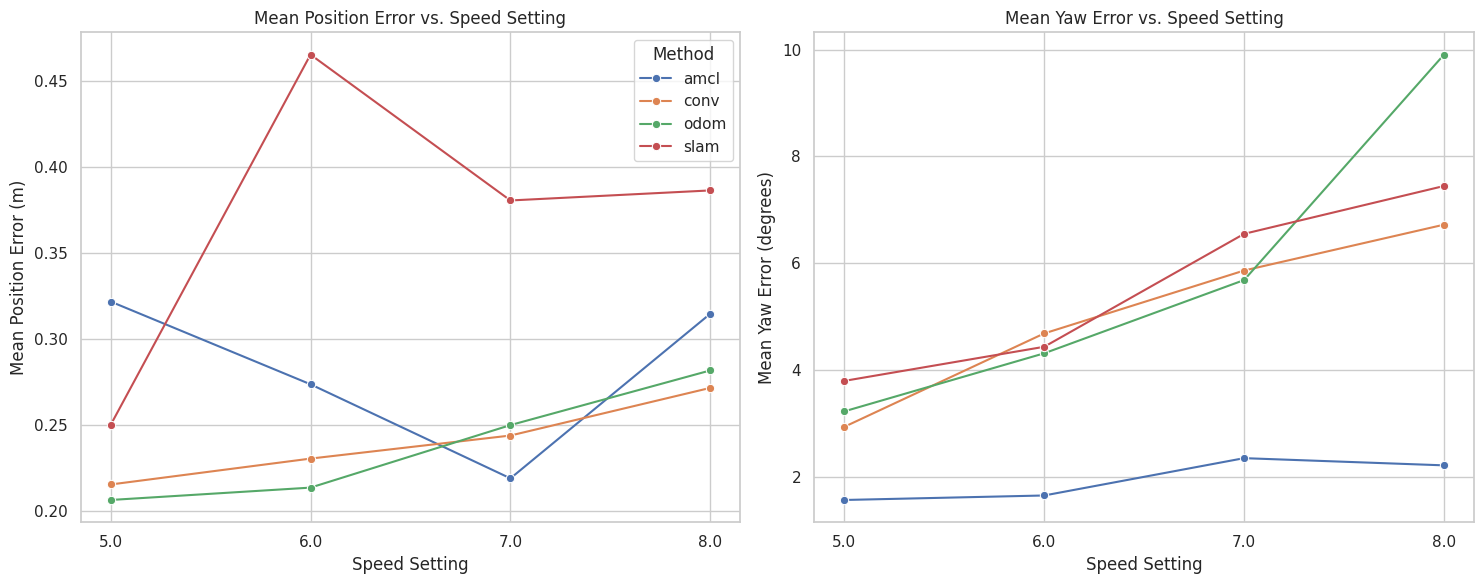

In [108]:
performance_vs_speed = df.groupby(['method', 'speed_setting'])[['position_error', 'yaw_error_deg']].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Mean Position Error vs Speed
sns.lineplot(data=performance_vs_speed, x='speed_setting', y='position_error', hue='method', marker='o', ax=axes[0])
axes[0].set_title('Mean Position Error vs. Speed Setting')
axes[0].set_xlabel('Speed Setting')
axes[0].set_ylabel('Mean Position Error (m)')
axes[0].grid(True)
axes[0].legend(title='Method')

# Mean Yaw Error vs Speed
sns.lineplot(data=performance_vs_speed, x='speed_setting', y='yaw_error_deg', hue='method', marker='o', ax=axes[1])
axes[1].set_title('Mean Yaw Error vs. Speed Setting')
axes[1].set_xlabel('Speed Setting')
axes[1].set_ylabel('Mean Yaw Error (degrees)')
axes[1].grid(True)
axes[1].get_legend().remove() # Remove duplicate legend

plt.tight_layout()
# plt.savefig('performance_vs_speed.png')
plt.show()

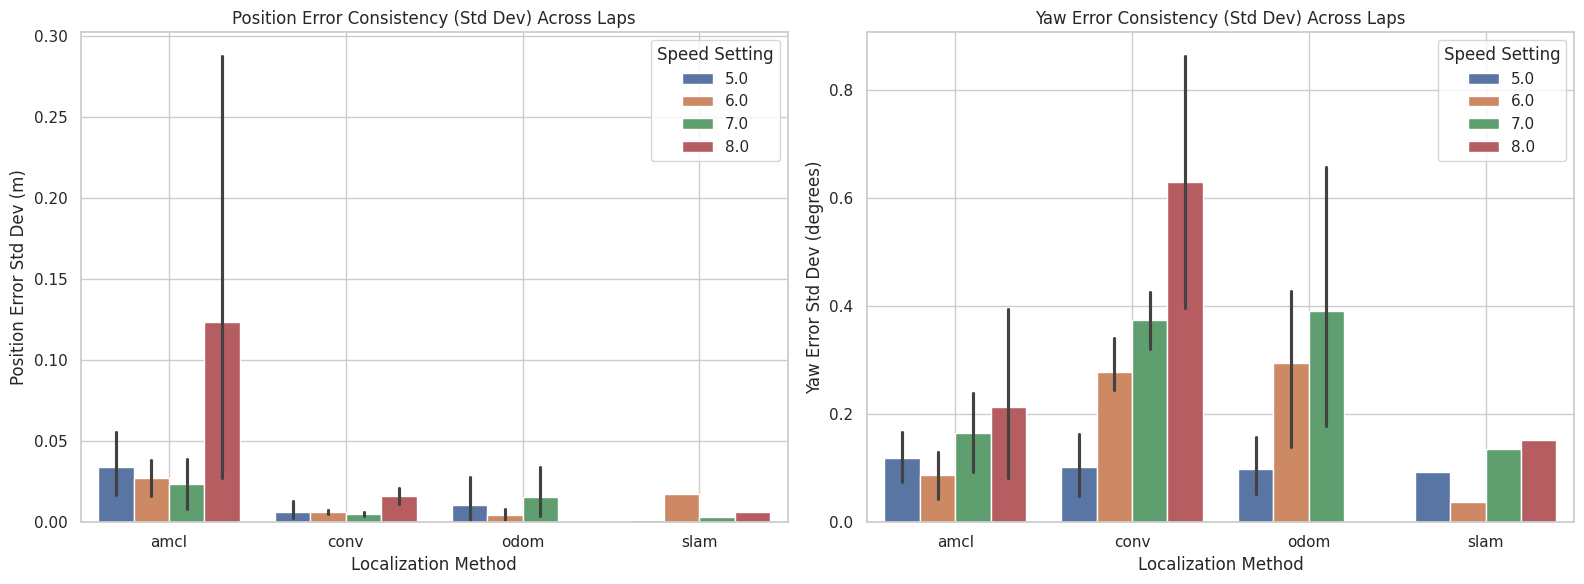

In [109]:
# Group data by track, speed, method, and lap to calculate mean errors for each lap
lap_consistency = df.groupby(['track', 'speed_setting', 'method', 'lap']).agg(
    mean_position_error=('position_error', 'mean'),
    mean_yaw_error_deg=('yaw_error_deg', 'mean')
).reset_index()

# Calculate the standard deviation of errors across laps for each track, speed, and method
lap_consistency_summary = lap_consistency.groupby(['track', 'speed_setting', 'method']).agg(
    position_error_std=('mean_position_error', 'std'),
    yaw_error_std=('mean_yaw_error_deg', 'std')
).reset_index()

# Plot the consistency metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot position error consistency
sns.barplot(data=lap_consistency_summary, x='method', y='position_error_std', hue='speed_setting', ax=axes[0])
axes[0].set_title('Position Error Consistency (Std Dev) Across Laps')
axes[0].set_xlabel('Localization Method')
axes[0].set_ylabel('Position Error Std Dev (m)')
axes[0].legend(title='Speed Setting')
axes[0].grid(True)

# Plot yaw error consistency
sns.barplot(data=lap_consistency_summary, x='method', y='yaw_error_std', hue='speed_setting', ax=axes[1])
axes[1].set_title('Yaw Error Consistency (Std Dev) Across Laps')
axes[1].set_xlabel('Localization Method')
axes[1].set_ylabel('Yaw Error Std Dev (degrees)')
axes[1].legend(title='Speed Setting')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 5. Quantitative Analysis (Tables)
#
# Calculate key statistics (Mean, Median, Std Dev, Max, RMSE) for position and yaw errors. This provides precise numbers for comparison, often essential for papers. Aggregate across laps for each track/speed/method combination.

# %%
# # Calculate statistics, grouping by track, speed, and method
# # Note: Aggregating across laps assumes you want the overall performance for that configuration.

In [110]:

summary_stats = df.groupby(['track', 'speed_setting', 'method']).agg(
    mean_pos_err=('position_error', 'mean'),
    median_pos_err=('position_error', 'median'),
    std_pos_err=('position_error', 'std'),
    max_pos_err=('position_error', 'max'),
    rmse_pos_err=('position_error', rmse), # Use the custom rmse function

    mean_yaw_err_deg=('yaw_error_deg', 'mean'),
    median_yaw_err_deg=('yaw_error_deg', 'median'),
    std_yaw_err_deg=('yaw_error_deg', 'std'),
    max_yaw_err_deg=('yaw_error_deg', 'max'),
    rmse_yaw_err_deg=('yaw_error_deg', rmse)
).reset_index()

# Display the table (or a part of it)
print("\nSummary Statistics Table (First 10 Rows):")
# pd.set_option('display.max_rows', None) # Uncomment to display all rows
print(summary_stats.round(4).head(10)) # Display with rounded values

# Optional: Save the full table to CSV
summary_stats.round(4).to_csv('localization_summary_stats.csv', index=False)


Summary Statistics Table (First 10 Rows):
       track speed_setting method  mean_pos_err  median_pos_err  std_pos_err  \
0  Spielberg           5.0   amcl        0.3979          0.3445       0.2831   
1  Spielberg           5.0   conv           NaN             NaN          NaN   
2  Spielberg           5.0   odom        0.3865          0.3685       0.2016   
3  Spielberg           6.0   amcl        0.3816          0.3001       0.2986   
4  Spielberg           6.0   conv           NaN             NaN          NaN   
5  Spielberg           6.0   odom           NaN             NaN          NaN   
6  Spielberg           7.0   amcl           NaN             NaN          NaN   
7  Spielberg           7.0   conv           NaN             NaN          NaN   
8  Spielberg           7.0   odom           NaN             NaN          NaN   
9  Spielberg           8.0   amcl        0.4994          0.3363       0.4842   

   max_pos_err  rmse_pos_err  mean_yaw_err_deg  median_yaw_err_deg  \
0     


# %% [markdown]
# ### Overall Performance Summary
#
# You might also want a table showing the *overall* average performance across all tracks and speeds for each method.

# %%

In [111]:

overall_summary = df.groupby('method').agg(
    overall_mean_pos_err=('position_error', 'mean'),
    overall_median_pos_err=('position_error', 'median'),
    overall_rmse_pos_err=('position_error', rmse),
    overall_max_pos_err=('position_error', 'max'),

    overall_mean_yaw_err_deg=('yaw_error_deg', 'mean'),
    overall_median_yaw_err_deg=('yaw_error_deg', 'median'),
    overall_rmse_yaw_err_deg=('yaw_error_deg', rmse),
    overall_max_yaw_err_deg=('yaw_error_deg', 'max')
).reset_index()

print("\nOverall Performance Summary Across All Conditions:")
print(overall_summary.round(4))
# Optional: Save this table
overall_summary.round(4).to_csv('overall_performance_summary.csv', index=False)


Overall Performance Summary Across All Conditions:
  method  overall_mean_pos_err  overall_median_pos_err  overall_rmse_pos_err  \
0   amcl                0.2935                  0.2130                0.4027   
1   conv                0.2332                  0.2145                0.2701   
2   odom                0.2221                  0.1986                0.2792   
3   slam                0.3968                  0.3714                0.4633   

   overall_max_pos_err  overall_mean_yaw_err_deg  overall_median_yaw_err_deg  \
0               2.5498                    1.7916                      0.9537   
1               2.2903                    4.4843                      3.2913   
2               2.6077                    4.3734                      3.0242   
3               1.3531                    5.0690                      3.3252   

   overall_rmse_yaw_err_deg  overall_max_yaw_err_deg  
0                    2.9219                 164.0019  
1                    6.2343         


# %% [markdown]
# ## 6. Discussion
#
# * **Interpret Trajectories:** Did the new method follow the ground truth more closely than others? Were there specific parts of tracks (e.g., sharp turns) where some methods performed better or worse?
# * **Analyze Error Plots:** Compare the magnitude and consistency of errors from the time-series and box plots. Does the new method have lower median error? Smaller variance (tighter box)? Fewer outliers?
# * **Evaluate Speed Robustness:** How did the errors for each method change with increasing speed (performance vs. speed plots)? Is the new method more robust to higher speeds?
# * **Examine Quantitative Tables:** Use the RMSE, mean, median, and max error values from the tables to make direct quantitative comparisons. For localization, RMSE (Absolute Trajectory Error - ATE) is a very common metric in literature. Lower values are better. Median error is good for robustness against outliers. Max error shows worst-case performance.
# * **Consider Track Differences:** Did performance vary significantly across the 7 different tracks (check the detailed summary stats table)? This indicates robustness to different environments.
# * **Limitations:** Acknowledge any limitations, such as the accuracy of the ground truth system itself, or the fact that computational performance wasn't measured here (though crucial for real-time apps).



# %% [markdown]
# ## 7. Conclusion
#
# Summarize the key findings. Based on the evidence (plots and tables), state whether your new localization method demonstrates improved performance (accuracy, consistency, robustness to speed/track) compared to the SOTA methods under the tested conditions. Highlight its strengths and any potential weaknesses observed.
